In [1]:
import json
import pandas as pd
from matplotlib.pylab import plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn_pandas import DataFrameMapper

# Exploratory Data Analysis
The first step is to read in the data.

In [2]:
logins = pd.read_json('data/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Next I made the login_time column the index to support time-based aggregation operations.

In [3]:
logins.index = logins.login_time
logins = logins.drop('login_time', 1)
logins['logins'] = 1
logins.head()

,logins
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


I then resampled the data in 15-minute intervals and get the number of logins in each window.

In [4]:
logins_15min = logins.resample('15min').count()
logins_15min.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Plotting all the data shows regular peaks, but it is difficult to decipher any trends between the peaks.

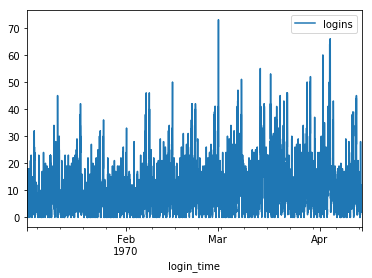

In [5]:
logins_15min.plot()
plt.show()

Plotting data for the month of March shows four rough peaks with many smaller peaks between.

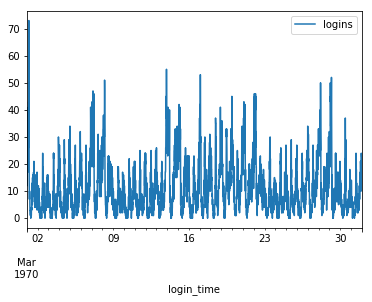

In [6]:
period = pd.Period('March 1970')
logins_15min[[period.start_time <= x <= period.end_time for x in logins_15min.index]].plot()
plt.show()

Further narrowing the plot to a few days shows roughly two peaks per day.

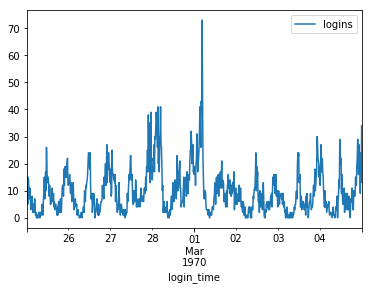

In [7]:
logins_15min[('1970-02-25' < logins_15min.index) & (logins_15min.index < '1970-03-05')].plot()
plt.show()

There appears to be a 12-hour cycle with peaks each day around midnight and noon.

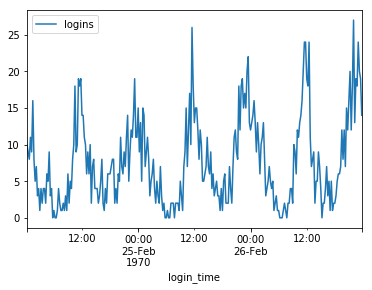

In [8]:
logins_15min[('1970-02-24' < logins_15min.index) & (logins_15min.index < '1970-02-027')].plot()
plt.show()

# Experiment and Metrics Design
I would look at the number of tolls collected during the week as the measure of success for encouraging driver partners to be available in both cities. I chose this metric because weekday tolls are likely to be made up of a higher percentage of driver partners than on weekends given the complementary circadian rhythms of the two cities. I would expect an increase in weekday tolls collected to be highly correlated with an increase in driver partner availability.

I would propose an A/B test that measures the number of tolls collected during the week with and without toll reimbursement to see if the difference is statistically significant. If numbers for toll collection under normal operating conditions are already available, then the experiment may skip to toll reimbursement. If the cities can collect enough data to provide reliable estimates of the mean and standard deviations for the number of tolls collected during the week, then they can use a z-test. If this is not feasible, then they should use a t-test instead. Once the data is collected for the two modes of operation, the cities should apply the selected test type with the null hypothesis that toll reimbursement has no impact on the number of tolls collected.

Once the experiment is complete and assuming there is a statistically significant increase in driver partner availability, the cities must decide if they want to conduct additional experiments with lower toll prices, only collect weekend tolls, or stop collecting tolls altogether. Given the activity of both cities, it does not seem like there would be many tolls collected during the week given that driver partners tend to be exclusive to each city. Therefore, the cities could potentially save money by not having toll collectors staffed during the week.

# Predictive Modeling
The first step is to read in the data. For some reason the Pandas read_json function could not read the file, so I resorted to the built-in json module.

In [9]:
# using json module because pd.read_json threw an error
f = open('data/ultimate.json')
data = json.load(f)
f.close()

Next I created the Pandas DataFrame.

In [10]:
users = pd.DataFrame(data)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


I then added the active column indicating users that took a trip in the previous 30 days. I used a period of 2 months to account for users whose last ride was July 1.

In [11]:
# convert strings to datetimes to support time operations
users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)

# use 2M to capture those whose last ride was on 2014-07-01
period = pd.Period('June 2014', freq='2M')
users['active'] = users.last_trip_date.apply(lambda d: period.start_time < d < period.end_time)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


I then removed entries with missing values. The resulting dataset was 83% the size of the original dataset.

In [12]:
len_orig = len(users)
users = users.dropna()
print(len(users) / len_orig)

0.8289


Forty percent of the remaining users were considered active. This is close enough to being balanced that resampling is probably not necessary.

In [13]:
print('{:.2f}% of all users were active'.format(100 * sum(users.active) / len(users)))

40.07% of all users were active


I then wanted to investigate the active percentages of different groupings of the dataset. Over half of Ultimate Black users were active, while only about 30% of regular users were active.

In [14]:
i = users.ultimate_black_user
print('{:.2f}% of the {} Ultimate Black users were active'.format(100 * sum(users.active[i]) / sum(i), sum(i)))
print('{:.2f}% of the {} regular users were active'.format(100 * sum(users.active[~i]) / sum(~i), sum(~i)))

53.86% of the 15919 Ultimate Black users were active
31.47% of the 25526 regular users were active


Nearly 65% of users in King's Landing were active, while only 38% of users in Winterfell and 27% in Astapor were active.

In [15]:
grouped = users.groupby('city')

for city in grouped.groups.keys():
    group = grouped.get_group(city)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} users in {} were active'.format(pct, len(group), city))

26.97% of the 13509 users in Astapor were active
64.81% of the 8775 users in King's Landing were active
37.98% of the 19161 users in Winterfell were active


Almost 48% of iPhone users were active, while only 22% of Android users were active.

In [16]:
grouped = users.groupby('phone')

for phone in grouped.groups.keys():
    group = grouped.get_group(phone)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} {} users were active'.format(pct, len(group), phone))

21.77% of the 12093 Android users were active
47.61% of the 29352 iPhone users were active


Grouping users by city and phone type show that the percentage of active users ranges from almost 71% active (iPhone users in King's Landing) down to below 12% active (Android users in Astapor).

In [17]:
grouped = users.groupby(['city', 'phone'])

for k in grouped.groups.keys():
    group = grouped.get_group(k)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} {} users in {} users were active'.format(pct, len(group), k[1], k[0]))

11.43% of the 4190 Android users in Astapor users were active
33.96% of the 9319 iPhone users in Astapor users were active
45.67% of the 2104 Android users in King's Landing users were active
70.84% of the 6671 iPhone users in King's Landing users were active
20.57% of the 5799 Android users in Winterfell users were active
45.53% of the 13362 iPhone users in Winterfell users were active


Next I created a DataFrameMapper from the sklearn-pandas module to transform the dataset to a format suitable for a scikit-learn classifier.

In [18]:
mapper = DataFrameMapper([
    (['avg_dist'], None),
    (['avg_rating_by_driver'], None),
    (['avg_rating_of_driver'], None),
    (['avg_surge'], None),
    (['surge_pct'], None),
    (['weekday_pct'], None),
    ('trips_in_first_30_days', None),
    ('ultimate_black_user', None),
    ('city', LabelEncoder()),
    ('phone', LabelEncoder())
])

I used a pipeline with the mapper followed by a random forest, which works well for a variety of problems. I experimented with other algorithms such as logistic regression and a multilayer perceptron, but they did not perform as well for this problem.

In [19]:
random_state = 8
model = Pipeline([
    ('map', mapper),
    ('clf', RandomForestClassifier(n_estimators=25, random_state=random_state))
])

I used a 10-fold stratified cross-validation to evaluate the models. This provides a good indication if the model generalizes well. The cell below displays accuracy, precision, and recall scores for the random forest. The model correctly predicts over 75% of instances in the dataset and has a recall score of 68%. We are probably more interested in recall for this problem since we want to predict users that will be active.

In [20]:
kfold = StratifiedKFold(n_splits=10, random_state=random_state)
print('Accuracy: {:.4f}'.format(cross_val_score(model, users, users.active, cv=kfold, scoring='accuracy').mean()))
print('Precision: {:.4f}'.format(cross_val_score(model, users, users.active, cv=kfold, scoring='precision').mean()))
print('Recall: {:.4f}'.format(cross_val_score(model, users, users.active, cv=kfold, scoring='recall').mean()))

Accuracy: 0.7527
Precision: 0.6942
Recall: 0.6845


Lastly, I fit the model on the entire dataset to investigate the weights of the features used in the model. The weights below indicate that average distance and weekday percentage are the most important features in the model, which is intuitive because it provides a measure of how often and how far users are riding. High weekday percentages could indicate rides are taken on a regular schedule, which would lead to higher active rates. Other key indicators include ratings, surges, the the number of trips in the first month. Ultimate could use this information to provide discounts to new users and encourage additional trips in the first 30 days. They could also experiment with surge pricing and frequency to see if rentention rates improve.

In [21]:
model.fit(users, users.active)
features = [x[0] for x in mapper.get_params()['features']]
features = [x if type(x) is str else x[0] for x in features]
weights = dict(zip(features, model.get_params()['clf'].feature_importances_))
for key, value in weights.items():
    print('{}: {:.4f}'.format(key, value))

avg_dist: 0.2783
avg_rating_by_driver: 0.1108
avg_rating_of_driver: 0.0779
avg_surge: 0.0734
surge_pct: 0.0853
weekday_pct: 0.1453
trips_in_first_30_days: 0.0801
ultimate_black_user: 0.0335
city: 0.0722
phone: 0.0430
